In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
sns.set()

In [2]:
PATH = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
total = 0
for dirs, dis, files in os.walk(os.path.join(PATH, 'train')):
    dis.sort()
    total += len(files)
print('total image in train datasets', total)

total = 0
for dirs, dis, files in os.walk(os.path.join(PATH, 'valid')):
    dis.sort()
    total += len(files)
print('total image in valid datasets', total)

total image in train datasets 70295
total image in valid datasets 17572


In [3]:
def getDF(labels, subpath, df):
    for i, (dirs, dist, files) in enumerate(os.walk(os.path.join(PATH, subpath))):
        if i == 0:
            continue
        dist.sort()
        lst = [os.path.join(dirs, f) for f in files]
        ones, zeros = np.ones(len(lst), dtype = np.int8), labels[i] + np.zeros(len(lst), dtype = np.int8)
        dft = pd.DataFrame(list(zip(lst,zeros)), columns = df.columns)
        df = df.append(dft, ignore_index = True)
    df['label'] = df['label'].astype('str')
    return df
        
    
labels = ['bacteria', 'blignt', 'disease', 'healthy', 'rust', 'powdery']
labelsVal = [-1,2,1,4,3,3,5,3,5,4,1,3,1,2,1,3,2,0,3,0,3,1,1,3,3,3,5,2,3,0,1,1,2,1,2,2,2,2,3]

df = pd.DataFrame(columns = ['img','label'])
df = getDF(labelsVal, 'train', df)
df = getDF(labelsVal, 'valid', df)


In [4]:
def splitDataSets(train, val, test, df, verb = False):
    lenght = len(df)
    bincount = np.bincount(df['label'].astype(int))
    minVal = bincount[np.argmin(bincount)]
    testMin = int(test * minVal)
    valMin = int(val * minVal)
    
    testDF = pd.DataFrame(columns = df.columns)
    valDF = pd.DataFrame(columns = df.columns)
    trainDF = pd.DataFrame(columns = df.columns)
    
    for i in range(6):
        tdf = pd.DataFrame(columns = df.columns)
        tdf = tdf.append(df[df['label'] == str(i)], ignore_index = True)
        idx = np.random.choice(len(tdf), testMin + valMin, False)
        
        testDF = testDF.append(tdf.loc[:int(testMin)], ignore_index = True)
        valDF = valDF.append(tdf.loc[int(testMin): len(idx)], ignore_index = True)
        trainDF = trainDF.append(tdf.loc[len(idx):], ignore_index = True)
        
    if verb == True:
        print(trainDF.shape, np.bincount(trainDF['label']))
        print(valDF.shape, np.bincount(valDF['label']))
        print(testDF.shape, np.bincount(testDF['label']))
    
    return trainDF, valDF, testDF
df = df.sample(frac = 1)
df.head(15)
trainDF, valDF, testDF = splitDataSets(0.85, 0.1, 0.05, df)



<BarContainer object of 6 artists>

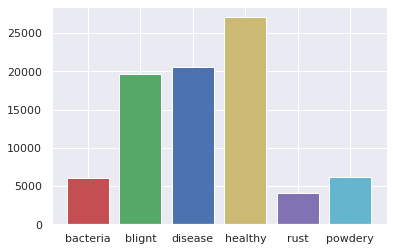

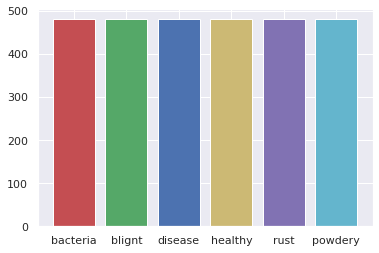

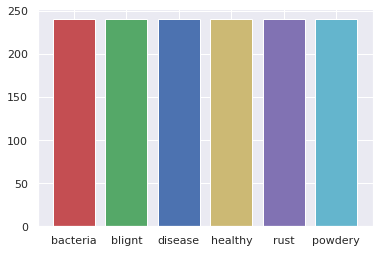

In [5]:
plt.bar(np.arange(6), np.bincount(trainDF['label']), tick_label  = labels, color = ['r','g','b','y','m','c'])
plt.figure()
plt.bar(np.arange(6), np.bincount(valDF['label']), tick_label  = labels, color = ['r','g','b','y','m','c'])
plt.figure()
plt.bar(np.arange(6), np.bincount(testDF['label']), tick_label  = labels, color = ['r','g','b','y','m','c'])

In [6]:
trainGen = ImageDataGenerator(rescale = 1./255,
                          rotation_range = 0.2,
                          width_shift_range = 0.1,
                          height_shift_range = 0.1,
                          zoom_range = 0.25,
                          horizontal_flip = True,
                          vertical_flip = True)
testGen = ImageDataGenerator(rescale = 1./255)

trainFlow = trainGen.flow_from_dataframe(trainDF, x_col = 'img', y_col = 'label', validate_filenames = True)
valFlow = testGen.flow_from_dataframe(valDF, x_col = 'img', y_col = 'label', validate_filenames = True)
testFlow = testGen.flow_from_dataframe(testDF, x_col = 'img', y_col = 'label', validate_filenames = True)

Found 83559 validated image filenames belonging to 6 classes.
Found 2880 validated image filenames belonging to 6 classes.
Found 1440 validated image filenames belonging to 6 classes.


In [7]:
res = ResNet50(include_top = False, input_shape = (256, 256, 3))
flag = False
for l in res.layers:
    if l.name == 'conv5_block1_1_conv':
        flag = True
    l.trainable = flag
he_weights = HeNormal()
model = Sequential()
model.add(res)
model.add(Conv2D(128, (1,1), activation = 'relu', kernel_initializer = he_weights))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu', kernel_initializer = he_weights))
model.add(Dense(128, activation = 'relu', kernel_initializer = he_weights))
model.add(Dense(6, activation = 'softmax', kernel_initializer = he_weights))
model.summary()
model.compile('adam', 'categorical_crossentropy', ['acc', 'Precision', 'AUC'])

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         262272    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________

In [8]:
logdir = 'logs'

class My_callback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs['acc'] > 0.93):
            self.model.stop_training = True    

esCallback = EarlyStopping(monitor = 'acc', patience = 3)
mcCallback = ModelCheckpoint(filepath = 'modelOn.hdf5', monitor = 'val_loss', save_best_only = True)
lrCallback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3)
tbCallback = TensorBoard(log_dir = logdir)
csCallback = My_callback()

In [9]:
history = model.fit(trainFlow,
         epochs = 15,
         validation_data = valFlow,
         callbacks = [tbCallback,csCallback, lrCallback, esCallback, mcCallback],
)

Epoch 1/15
2612/2612 [==============================] - 1566s 600ms/step - loss: 1.5114 - acc: 0.3653 - precision: 0.5591 - auc: 0.7543 - val_loss: 1.9459 - val_acc: 0.2688 - val_precision: 0.3949 - val_auc: 0.6370
Epoch 2/15
2612/2612 [==============================] - 1419s 543ms/step - loss: 1.3367 - acc: 0.4431 - precision: 0.6009 - auc: 0.8120 - val_loss: 1.6044 - val_acc: 0.3549 - val_precision: 0.4404 - val_auc: 0.7454
Epoch 3/15
2612/2612 [==============================] - 1440s 551ms/step - loss: 1.2365 - acc: 0.4907 - precision: 0.6392 - auc: 0.8414 - val_loss: 4.6282 - val_acc: 0.2010 - val_precision: 0.2073 - val_auc: 0.5465
Epoch 4/15
2612/2612 [==============================] - 1486s 569ms/step - loss: 1.1624 - acc: 0.5251 - precision: 0.6639 - auc: 0.8610 - val_loss: 1.3452 - val_acc: 0.4983 - val_precision: 0.6248 - val_auc: 0.8242
Epoch 5/15
2612/2612 [==============================] - 1485s 568ms/step - loss: 1.1064 - acc: 0.5535 - precision: 0.6801 - auc: 0.8748 - va

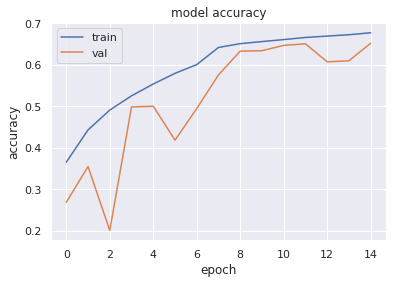

In [10]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

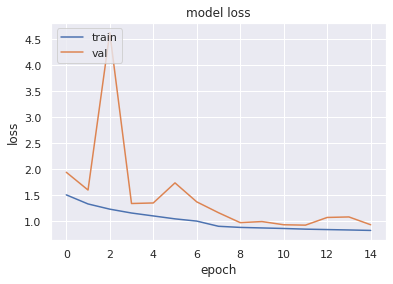

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

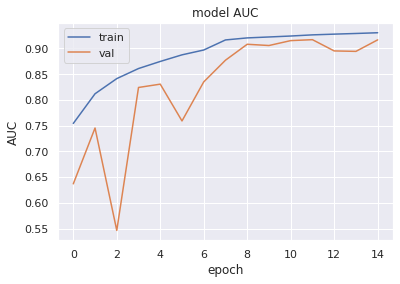

In [12]:
plt.figure()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

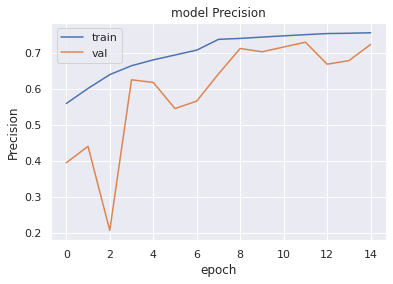

In [13]:
plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()